In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip dataset
!unzip -uq "/content/drive/MyDrive/data.zip" -d "/content/drive/MyDrive/Dataset"

warning [/content/drive/MyDrive/data.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/data.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...


#### PyDrive is a high-level Python wrapper for the Google Drive API. It allows you to easily upload, download, and delete files in your Google Drive from a Python script.

In [ ]:
# Import PyDrive and associated libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

mimetypes = {
    'application/vnd.google-apps.document': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
    'application/vnd.google-apps.spreadsheet': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet'
}

# Download dataset based on its file ID
file_id = '1i9FCxrHy2GhhiO2f5e2yvSCw-pn8iwyA'
downloaded = drive.CreateFile({'id': file_id})


if downloaded['mimeType'] in mimetypes:
  download_mimetype = mimetypes[downloaded['mimeType']]
  downloaded.GetContentFile(downloaded['title'], mimetype=download_mimetype)

In [ ]:
# Access dataset from drive
import os
import glob
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
  
img_list = glob.glob('/content/drive/MyDrive/Data/*/*')
print(len(img_list))

153610


In [ ]:
# List the directories of dataset
import os 
path = '/content/drive/MyDrive/Data'
print(os.listdir(path))

['lion', 'snake', 'cell phone', 'keyboard', 'carrot', 'wineglass', 'elephant', 'door', 'cake', 'knife', 'pineapple', 'squirrel', 'horse', 'sea turtle', 'cow', 'tomato', 'toothbrush', 'microscope', 'fish', 'traffic light', 'frog', 'tire', 'laptop', 'backpack', 'hamburger', 'purse', 'arm', 'ship', 'bicycle', 'pizza', 'axe', 'socks', 'fan', 'octopus', 'banana', 'lightbulb', 'rabbit', 'rooster', 'head-phones', 'scissors', 'flashlight', 'hat', 'brain', 'spoon', 'bell', 'eyeglasses', 'bread', 'monkey', 'spider', 'house', 'kangaroo', 'book', 'mouse (animal)', 'trousers', 'satellite', 'skateboard', 'mug', 'cloud', 'train', 'umbrella', 'bird', 'crane (machine)', 'grapes', 'table', 'frying-pan', 'santa claus', 'parachute', 'parrot', 'airplane', 'skyscraper', 'bowl', 'envelope', 'truck', 't-shirt', 'pen', 'ice-cream-cone', 'telephone', 'ear', 'bear (animal)', 'teddy-bear', 'wine-bottle', 'wrist-watch', 'vase', 'mouth', 'comb', 'loudspeaker', 'snowboard', 'key', 'motorbike', 'tv', 'chair', 'van', 

In [ ]:
# Access only the apple and banana images of dataset 

import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

img_data_list=[]
for dir in (os.listdir(path)):
  if dir in ['apple', 'banana']:
    images = os.listdir(os.path.join(path,dir))
    for imge in images:
      img_path = path+'/'+dir+'/'+imge
      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      img_data_list.append(x)

print(len(img_data_list))

1920


In [ ]:
img_data = np.array(img_data_list)
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(1920, 1, 224, 224, 3)
(1, 1920, 224, 224, 3)
(1920, 224, 224, 3)


In [ ]:
# Define number of classes

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

num_classes = 2
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:960]=0
labels[960:]=1
names = ['banana','apple']

# convert class labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
print(X_train.shape)
print(y_train.shape)

(1536, 224, 224, 3)
(1536, 2)


In [ ]:
print(X_test.shape)

(384, 224, 224, 3)


**Transfer learning for classifier alone**

In [ ]:
# Train model in batches of dataset
import os
import time
import sklearn
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor = image_input, include_top = True, weights = 'imagenet')
model.summary()

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

# Train classifier and freeze other layers

for layer in custom_vgg_model2.layers[:-1]:
	layer.trainable = False
custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

t=time.time()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (time.time() - t))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

# Save model to drive
custom_vgg_model2.save('drive/MyDrive/custom_vgg_model2.hdf5')

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

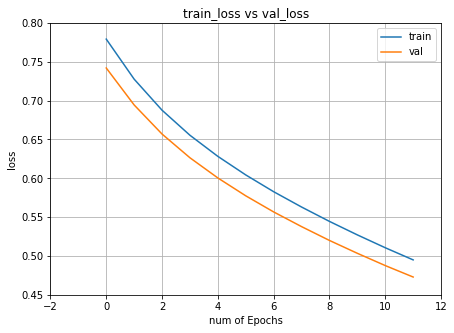

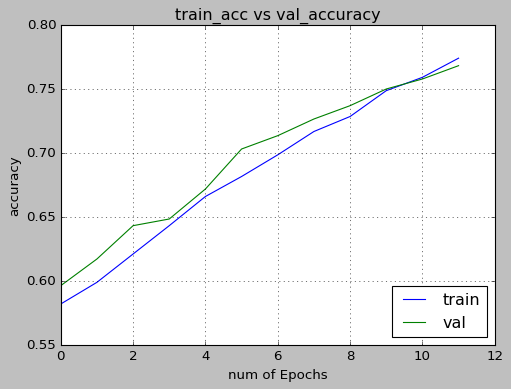

In [ ]:
# plotting losses and accuracy

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(12)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_accuracy')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [2]:
# Recreate the exact same model, including its weights and the optimizer
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
new_model = tf.keras.models.load_model('drive/MyDrive/custom_vgg_model2.hdf5')

# Show the model architecture
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Predict the test images
predictions = new_model.predict(X_test[:10])

# Print model predictions
print(np.argmax(predictions, axis=1))

[0 0 0 0 0 0 1 1 0 1]


In [ ]:
# Print corresponding classes
print(np.argmax(y_test[:10], axis=1))

[0 0 1 0 1 0 1 1 0 1]


In [4]:
# Testing for new images 
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

testing_path = '/content/drive/MyDrive/Testing'

images = os.listdir(testing_path)
for imge in images:
  img_path = testing_path+ '/' +imge
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #print('Input image shape:', x.shape)

  preds = new_model.predict(x)
  print(imge, np.argmax(preds, axis=1))
  #print(preds)

apple2.png [1]
apple.png [1]
banana.png [0]
banana2.png [0]
banana3.png [1]
banana7.png [0]
banana8.png [0]
banana9.png [0]
banana10.png [0]
banana11.png [0]
banana12.png [0]
banana13.png [0]
banana14.png [0]
banana15.png [0]
banana16.png [0]
banana4.png [1]
banana5.png [0]
banana6.png [0]
apple11.png [1]
apple6.png [0]
apple13.png [0]
apple14.png [1]


**Transfer learning for dense layers**

In [ ]:
# Train model in batches of dataset
import os
import time
import sklearn
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor = image_input, include_top = True, weights = 'imagenet')
model.summary()

last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_dense_model2 = Model(image_input, out)
custom_dense_model2.summary()

# Train fully connected layers and freeze other layers

for layer in custom_dense_model2.layers[:-3]:
	layer.trainable = False
custom_dense_model2.summary()

custom_dense_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

t=time.time()
hist = custom_dense_model2.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (time.time() - t))
(loss, accuracy) = custom_dense_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

# Save model to drive
custom_dense_model2.save('drive/MyDrive/custom_dense_model2.hdf5')

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))



553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

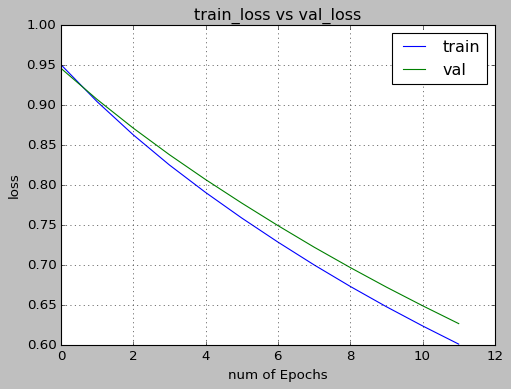

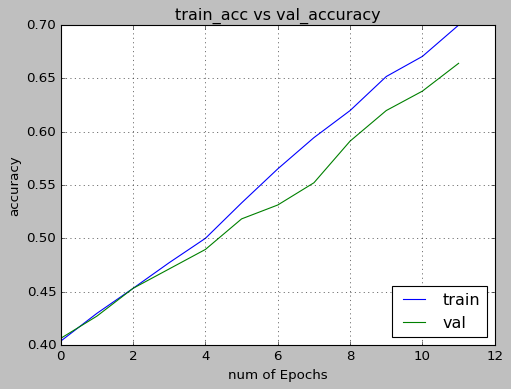

In [ ]:
# plotting losses and accuracy

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(12)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_accuracy')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [5]:
# Recreate the exact same model, including its weights and the optimizer
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
model = tf.keras.models.load_model('drive/MyDrive/custom_dense_model2.hdf5')

# Show the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Predict the test images
predictions = model.predict(X_test[:10])

# Print model predictions
print(np.argmax(predictions, axis=1))

[0 0 1 0 1 0 1 1 0 1]


In [ ]:
# Print corresponding classes
print(np.argmax(y_test[:10], axis=1))

[0 0 1 0 1 0 1 1 0 1]


In [6]:
# Testing for new images 
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

testing_path = '/content/drive/MyDrive/Testing'

images = os.listdir(testing_path)
for imge in images:
  img_path = testing_path +'/' +imge
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #print('Input image shape:', x.shape)

  preds = model.predict(x)
  print(imge, np.argmax(preds, axis=1))
  #print(preds)

apple2.png [1]
apple.png [1]
banana.png [0]
banana2.png [0]
banana3.png [0]
banana7.png [0]
banana8.png [0]
banana9.png [0]
banana10.png [0]
banana11.png [0]
banana12.png [0]
banana13.png [0]
banana14.png [0]
banana15.png [0]
banana16.png [0]
banana4.png [0]
banana5.png [0]
banana6.png [0]
apple11.png [0]
apple6.png [0]
apple13.png [1]
apple14.png [0]


**Code to train model for all classes**

In [ ]:
# Access the images of dataset 

import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

img_data_list=[]
for dir in (os.listdir(path)):
  images = os.listdir(os.path.join(path,dir))
  for imge in images:
    img_path = path+'/'+dir+'/'+imge
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_data_list.append(x)

print(len(img_data_list))

In [ ]:
# Create labels to classes of dataset
import glob
img_data_list = glob.glob('/content/drive/MyDrive/Data/*/*')

labels_folders = glob.glob(('/content/drive/MyDrive/Data/*'))

labels_list = [i.split("/")[-1] for i in labels_folders]
labels_numbers = [labels_list.index(i) for i in labels_list]
print("labels list: ", labels_list)
print("labels numbers: ", labels_numbers)

labels = {}
for index, label in enumerate(labels_list):
  labels[label] = labels_numbers[index]

print(labels)

labels list:  ['lion', 'snake', 'cell phone', 'keyboard', 'carrot', 'wineglass', 'elephant', 'door', 'cake', 'knife', 'pineapple', 'squirrel', 'horse', 'sea turtle', 'cow', 'tomato', 'toothbrush', 'microscope', 'fish', 'traffic light', 'frog', 'tire', 'laptop', 'backpack', 'hamburger', 'purse', 'arm', 'ship', 'bicycle', 'pizza', 'axe', 'socks', 'fan', 'octopus', 'banana', 'lightbulb', 'rabbit', 'rooster', 'head-phones', 'scissors', 'flashlight', 'hat', 'brain', 'spoon', 'bell', 'eyeglasses', 'bread', 'monkey', 'spider', 'house', 'kangaroo', 'book', 'mouse (animal)', 'trousers', 'satellite', 'skateboard', 'mug', 'cloud', 'train', 'umbrella', 'bird', 'crane (machine)', 'grapes', 'table', 'frying-pan', 'santa claus', 'parachute', 'parrot', 'airplane', 'skyscraper', 'bowl', 'envelope', 'truck', 't-shirt', 'pen', 'ice-cream-cone', 'telephone', 'ear', 'bear (animal)', 'teddy-bear', 'wine-bottle', 'wrist-watch', 'vase', 'mouth', 'comb', 'loudspeaker', 'snowboard', 'key', 'motorbike', 'tv', 'c

In [ ]:
# Train model in batches of dataset
import os
import time
import sklearn
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor = image_input, include_top = True, weights = 'imagenet')
model.summary()

last_layer = model.get_layer('fc2').output
out = Dense(160, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

# Train classifier and freeze other layers

for layer in custom_vgg_model2.layers[:-1]:
	layer.trainable = False
custom_vgg_model2.summary()
  

t = list(zip(img_data_list, labels_numbers))
shuffle(t)
src_filepaths, labels = zip(*t)

m = len(src_filepaths) 
batch_size = 1280

for i in range(60):
  print(i)
  start_pos = i * batch_size
  end_pos = min(start_pos + batch_size, m)
  src_filepaths_batch = img_data_list[start_pos: end_pos]
  labels_batch = labels[start_pos: end_pos]
  
  imgs = []
  for img_path in src_filepaths_batch:
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    imgs.append(x)

  X = np.array(imgs)
  print (X.shape)
  X=np.rollaxis(X,1,0)
  print (X.shape)
  X=X[0]
  print (X.shape)
  
  Y = np_utils.to_categorical(labels_batch, 160)
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
  custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
  t=time.time()
  hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
  print('Training time: %s' % (time.time() - t))
  (loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

  print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


# Save model to drive
custom_vgg_model.save('model.hdf5')

**Training for 4 classes**

In [ ]:
# Access only the apple, banana, grapes, strawberry images of dataset 

import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

images_list=[]
for dir in (os.listdir(path)):
  if dir in ['apple', 'banana', 'grapes', 'strawberry']:
    print(dir)
    images = os.listdir(os.path.join(path,dir))
    for imge in images:
      img_path = path+'/'+dir+'/'+imge
      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      images_list.append(x)

print(len(images_list))

banana
grapes
strawberry
apple
3840


In [ ]:
img_data = np.array(images_list)
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(3840, 1, 224, 224, 3)
(1, 3840, 224, 224, 3)
(3840, 224, 224, 3)


In [ ]:
# Define number of classes

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

num_classes = 4
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:960]=0
labels[960:1920]=1
labels[1920:2880]=2
labels[2880:3840]=3
names = ['banana','grapes', 'strawberry', 'apple']

# convert class labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
print(X_train.shape)
print(y_train.shape)

(3072, 224, 224, 3)
(3072, 4)


In [ ]:
# Train model in batches of dataset
import os
import time
import sklearn
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor = image_input, include_top = True, weights = 'imagenet')
model.summary()

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model4 = Model(image_input, out)
custom_vgg_model4.summary()

# Train classifier and freeze other layers

for layer in custom_vgg_model4.layers[:-1]:
	layer.trainable = False
custom_vgg_model4.summary()
custom_vgg_model4.layers[3].trainable

custom_vgg_model4.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

t=time.time()
hist = custom_vgg_model4.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (time.time() - t))
(loss, accuracy) = custom_vgg_model4.evaluate(X_test, y_test, batch_size=10, verbose=1)

# Save model to drive
custom_vgg_model4.save('drive/MyDrive/custom_vgg_model4.hdf5')

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


553476096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# plotting losses and accuracy

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(12)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_accuracy')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [ ]:
# Predict the test images
predictions = new_model.predict(X_test[:10])

#Print model predictions
print(np.argmax(predictions, axis=1))

#Print corresponding labels
print(np.argmax(y_test[:10], axis=1))

In [ ]:
# Testing for new images 
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

testing_path = '/content/drive/MyDrive/Testing'

images = os.listdir(testing_path)
for imge in images:
  img_path = testing_path +'/' +imge
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = new_model.predict(x)
  print(imge, np.argmax(preds, axis=1))